In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import datetime, os
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics
#from datetime import datetime
import io
import itertools
from packaging import version
%load_ext tensorboard
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping

logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

/home/mike/miniconda3/envs/tf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#paramaters for model
#NOTE THIS MODEL USES TENSORBOARD CALLBACKS and outputs on the cell above 
# for monitoring during training 
#if your directory dosent have logs then there will be no outputs until a run is complete
print(tf.__version__)
BATCH_SIZE=128
HEIGHT=480
WIDTH=640
NUM_CLASSES=10

2.10.0


In [3]:
#confirming gpu
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
#reading in the train and validation data
train_ds = tf.keras.utils.image_dataset_from_directory(
  "/home/mike/projects/CS682_final_project/Data/noBackground/train_data/",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(HEIGHT, WIDTH),
  batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  "/home/mike/projects/CS682_final_project/Data/noBackground/train_data/",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(HEIGHT, WIDTH),
  batch_size=BATCH_SIZE)



Found 22424 files belonging to 10 classes.
Using 17940 files for training.
Found 22424 files belonging to 10 classes.
Using 4484 files for validation.


In [5]:
#class names (really just the folder names of data were reading in)
class_names = train_ds.class_names
print(class_names)

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']


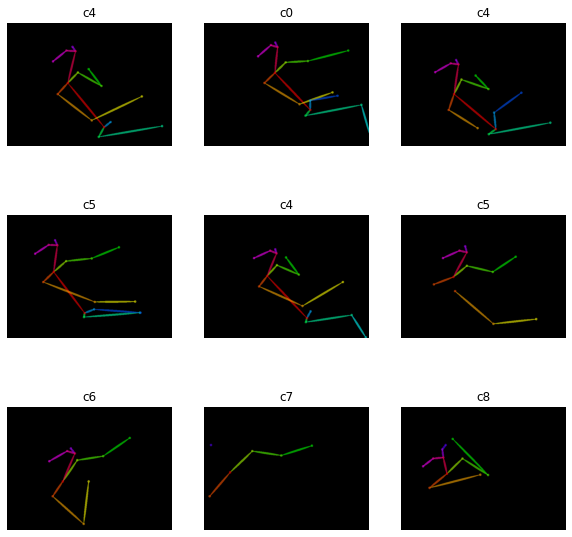

In [6]:
#plotting exampls of data we are reading in
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [7]:
#add this if you wish to experiment with augmentation
data_augmentation = keras.Sequential(
  [
#     layers.RandomFlip("horizontal",
#                       input_shape=(HEIGHT,
#                                   WIDTH,
#                                   3)),
#     layers.RandomRotation(0.1),
#     layers.RandomZoom(0.1),
   ]
)


In [8]:
#getting model to be used in transfer learning you can sub out "EfficientNetB7" with
# a different model if you wish to do transfer learning with a different model like
# VGG or ResNet
base_model = tf.keras.applications.efficientnet.EfficientNetB7(weights="imagenet", include_top=False, input_shape=(480,640,3))
base_model.trainable = False ## Not trainable weights

In [9]:
#defining model below comment out the base_model if you want to use a custom CNN
# uncomment the layers you want to use / add your own if you want to experiment with
# other models
model = keras.models.Sequential([
  # data_augmentation,
  base_model,
#   layers.Rescaling(1./255),
#   layers.Conv2D(64, 5, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Dropout(0.2),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Dropout(0.2),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Dropout(0.2),
#   layers.Conv2D(8, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Dropout(0.2),
#   layers.Conv2D(4, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
   layers.GlobalAveragePooling2D(),
   layers.BatchNormalization(),
   layers.Dropout(0.2),
    
#   layers.Dense(128, activation='relu'),
#   layers.Dropout(0.2), these two layers scored 3.72976
#   layers.Dense(64, activation='relu'),
   layers.Dense(NUM_CLASSES, activation='softmax', name="outputs")
])


In [10]:
# tensorboard callback for monitoring during training and compiling model
# uncomment es_callback if you want to use early stopping 
#NOTE EARLY STOPPING WILL CAUSE PLOTS OF ACCURACY AND LOSS TO FAIL BELOW
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
file_writer_cm = tf.summary.create_file_writer(log_dir + '/cm')
# es_callback = EarlyStopping(
#     monitor='val_loss',
#     patience=3,
#     verbose=1
# )

In [11]:
#summary of model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional)  (None, 15, 20, 2560)     64097687  
                                                                 
 global_average_pooling2d (G  (None, 2560)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 2560)             10240     
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 2560)              0         
                                                                 
 outputs (Dense)             (None, 10)                25610     
                                                                 
Total params: 64,133,537
Trainable params: 30,730
Non-

In [12]:
#training model
epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  callbacks=[tensorboard_callback],
  epochs=epochs
)

Epoch 1/100
141/141 [==============================] - 447s 3s/step - loss: 0.9531 - accuracy: 0.6939 - val_loss: 1.8118 - val_accuracy: 0.2618
Epoch 2/100
141/141 [==============================] - 428s 3s/step - loss: 0.5994 - accuracy: 0.8125 - val_loss: 1.2212 - val_accuracy: 0.6583
Epoch 3/100
141/141 [==============================] - 428s 3s/step - loss: 0.5170 - accuracy: 0.8375 - val_loss: 0.6220 - val_accuracy: 0.8519
Epoch 4/100
141/141 [==============================] - 435s 3s/step - loss: 0.4697 - accuracy: 0.8525 - val_loss: 0.4021 - val_accuracy: 0.8834
Epoch 5/100
141/141 [==============================] - 444s 3s/step - loss: 0.4464 - accuracy: 0.8576 - val_loss: 0.3407 - val_accuracy: 0.8983
Epoch 6/100
141/141 [==============================] - 438s 3s/step - loss: 0.4326 - accuracy: 0.8610 - val_loss: 0.3326 - val_accuracy: 0.9023
Epoch 7/100
141/141 [==============================] - 438s 3s/step - loss: 0.4084 - accuracy: 0.8677 - val_loss: 0.3269 - val_accuracy:

ValueError: x and y must have same first dimension, but have shapes (100,) and (19,)

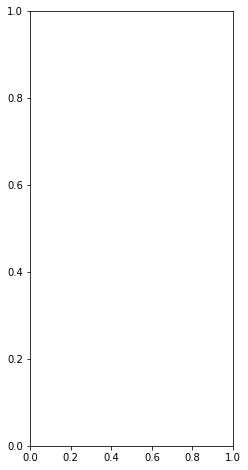

In [13]:
#IF THIS IS NOT WORKING DOUBLE CHECK THAT YOU DONT HAVE EARLY STOPPING ENABLED
# that is why the output for this cell is an error simply re run without early stopping to
# get loss and accuracy plots
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [14]:
#data that will be used to predict on and submit to kagggle make sure it only belongs to 1 class below
submission_data = tf.keras.utils.image_dataset_from_directory(
  "/home/mike/projects/CS682_final_project/Data/noBackground/newdir/",
  shuffle = False,
  image_size=(HEIGHT, WIDTH),
  batch_size=BATCH_SIZE)

Found 79726 files belonging to 1 classes.


In [15]:
#making predictions
out = model.predict(submission_data)

623/623 [==============================] - 1452s 2s/step


In [16]:
#confirming shape used for debugging
print(out.shape)

(79726, 10)


In [17]:
#creating columns used for submision
import pandas as pd
submission_df = pd.DataFrame(columns = ['img','c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
submission_df

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9


In [18]:
#since file names were adjusted when used on open pose need to read all in and adjust them to meet submission params
import glob
list_ = glob.glob(r"/home/mike/projects/CS682_final_project/Data/noBackground/test/*.png")
print(len(list_))

79726


In [19]:
#grabbing files to confirm their naming scheme
from itertools import islice
N = 3
first_n_items = islice(list_, N)
print(list(first_n_items)) 

['/home/mike/projects/CS682_final_project/Data/noBackground/test/img_39225_rendered.png', '/home/mike/projects/CS682_final_project/Data/noBackground/test/img_74300_rendered.png', '/home/mike/projects/CS682_final_project/Data/noBackground/test/img_41299_rendered.png']


In [20]:
#adjusting name of file before adding to DF
row = {}
for index,i in enumerate(list_):
    stripped = os.path.basename(i)
    stripped="_".join(stripped.split("_")[:2])
    stripped +=".jpg"
    row={"img":stripped,'c0':[out[index][0]], 'c1':[out[index][1]], 'c2':[out[index][2]], 'c3':[out[index][3]], 'c4':[out[index][4]], 'c5':[out[index][5]], 'c6':[out[index][6]], 'c7':[out[index][7]], 'c8':[out[index][8]], 'c9':[out[index][9]]}
    submission_df = pd.concat([submission_df, pd.DataFrame.from_records(row)])
    #submission_df=submission_df.append(row, ignore_index=True)

In [21]:
submission_df.head()

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_39225.jpg,0.000044,8.681821e-08,0.000166,9.955236e-01,4.086914e-03,0.000015,0.000005,3.907541e-07,0.000041,0.000118
0,img_74300.jpg,0.125782,4.367171e-06,0.009416,7.943334e-01,2.730978e-03,0.007499,0.002646,3.937487e-04,0.053427,0.003767
0,img_41299.jpg,0.000375,2.858748e-01,0.000241,6.290049e-02,7.763119e-02,0.000140,0.008308,5.725658e-03,0.004778,0.554026
0,img_32425.jpg,0.036406,4.449749e-01,0.000578,1.614348e-05,1.529930e-05,0.000218,0.000600,2.142272e-05,0.003776,0.513394
0,img_74593.jpg,0.000300,2.623805e-06,0.510951,6.597854e-10,3.173257e-08,0.000258,0.442701,3.731618e-07,0.045784,0.000004


In [22]:
submission_df

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_39225.jpg,0.000044,8.681821e-08,0.000166,9.955236e-01,4.086914e-03,0.000015,0.000005,3.907541e-07,0.000041,0.000118
0,img_74300.jpg,0.125782,4.367171e-06,0.009416,7.943334e-01,2.730978e-03,0.007499,0.002646,3.937487e-04,0.053427,0.003767
0,img_41299.jpg,0.000375,2.858748e-01,0.000241,6.290049e-02,7.763119e-02,0.000140,0.008308,5.725658e-03,0.004778,0.554026
0,img_32425.jpg,0.036406,4.449749e-01,0.000578,1.614348e-05,1.529930e-05,0.000218,0.000600,2.142272e-05,0.003776,0.513394
0,img_74593.jpg,0.000300,2.623805e-06,0.510951,6.597854e-10,3.173257e-08,0.000258,0.442701,3.731618e-07,0.045784,0.000004
...,...,...,...,...,...,...,...,...,...,...,...
0,img_1189.jpg,0.000063,1.273964e-04,0.245119,6.441616e-09,2.730740e-07,0.000215,0.744873,5.839358e-03,0.003730,0.000033
0,img_36273.jpg,0.824100,4.756240e-06,0.009691,3.254157e-06,7.663105e-05,0.135199,0.000038,1.119864e-05,0.027841,0.003035
0,img_76433.jpg,0.007325,9.195215e-05,0.000536,9.685130e-01,1.507886e-03,0.016862,0.001717,2.201515e-06,0.003319,0.000126
0,img_100535.jpg,0.000605,5.830295e-04,0.003100,2.103458e-07,6.063178e-06,0.000164,0.987743,2.102213e-06,0.007683,0.000113


In [23]:
#writing to csv for submission
submission_df.to_csv("efficientnetb7_nobackground_new_test.csv",index=False)